In [10]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow-gpu

  Using cached https://files.pythonhosted.org/packages/d5/cf/83a8b5aa711adcdbed5496618663ed99878b28e843593cb6b2fae6a59181/tensorflow_gpu-2.0.0-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/6a/9a/50fadfd53ec909e4399b67c74cc7f4e883488035cfcdb90b685758fa8b34/setuptools-41.4.0-py2.py3-none-any.whl
  Found existing installation: setuptools 28.8.0
    Uninstalling setuptools-28.8.0:
      Successfully uninstalled setuptools-28.8.0


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def generate_wave_set(n_support=1000, n_train=25, std=0.3):
    data = {}
    # выберем некоторое количество точек из промежутка от 0 до 2*pi
    data['support'] = np.linspace(0, 2*np.pi, num=n_support)
    # для каждой посчитаем значение sin(x) + 1
    # это будет ground truth
    data['values'] = np.sin(data['support']) + 1
    # из support посемплируем некоторое количество точек с возвратом, это будут признаки
    data['x_train'] = np.sort(np.random.choice(data['support'], size=n_train, replace=True))
    # опять посчитаем sin(x) + 1 и добавим шум, получим целевую переменную
    data['y_train'] = np.sin(data['x_train']) + 1 + np.random.normal(0, std, size=data['x_train'].shape[0])
    return data


data = generate_wave_set(1000, 250)

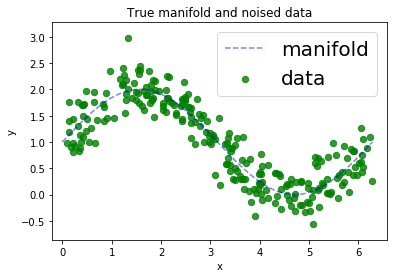

In [15]:
margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 20})
plt.title('True manifold and noised data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [16]:
# добавим колонку единиц к единственному столбцу признаков
X = np.array([np.ones(data['x_train'].shape[0]), data['x_train']]).T
# перепишем, полученную выше формулу, используя numpy
# шаг обучения - в этом шаге мы ищем лучшую гипотезу h
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), data['y_train'])
# шаг применения: посчитаем прогноз
y_hat = np.dot(w, X.T)

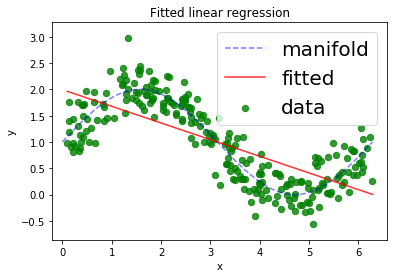

In [17]:
margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')

plt.plot(data['x_train'], y_hat, 'r', alpha=0.8, label='fitted')

plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 20})
plt.title('Fitted linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

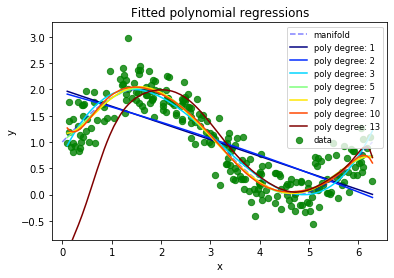

In [32]:
# список степеней p полиномов, который мы протестируем
degree_list = [1, 2, 3, 5, 7, 10, 13]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, len(degree_list))]

margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')

w_list = []
err = []
for ix, degree in enumerate(degree_list):
    # список с предрасчитанными степенями признака
    dlist = [np.ones(data['x_train'].shape[0])] + [data['x_train']**n for n in range(1, degree + 1)]
    X = np.array(dlist).T
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), data['y_train'])
    w_list.append((degree, w))
    y_hat = np.dot(w, X.T)
    err.append(np.mean((data['y_train'] - y_hat)**2))
    plt.plot(data['x_train'], y_hat, color=colors[ix], label='poly degree: %i' % degree)
plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 'small'})
plt.title('Fitted polynomial regressions')
plt.xlabel('x')
plt.ylabel('y')
plt.show() 

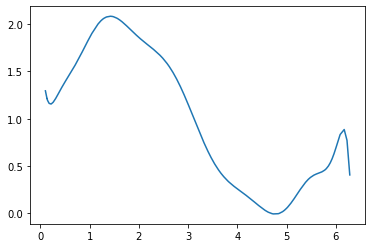

In [34]:
degree = 13
dlist = [np.ones(data['x_train'].shape[0])] + \
                list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
X = np.array(dlist).T

q, r = np.linalg.qr(X)

y_hat = np.dot(np.dot(q, q.T), data['y_train'])
plt.plot(data['x_train'], y_hat, label='poly degree: %i' % degree)

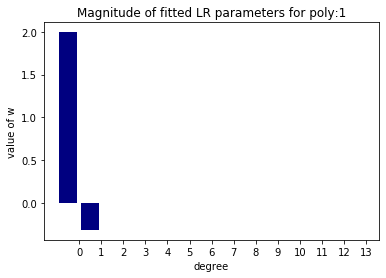

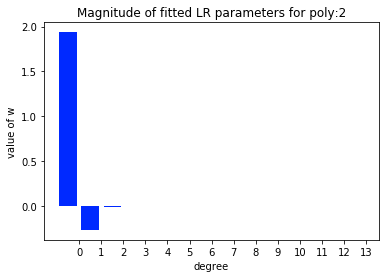

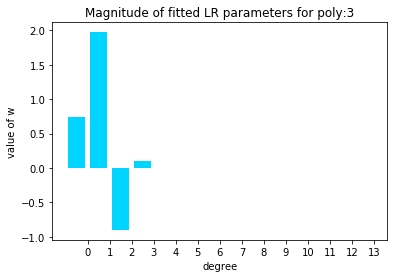

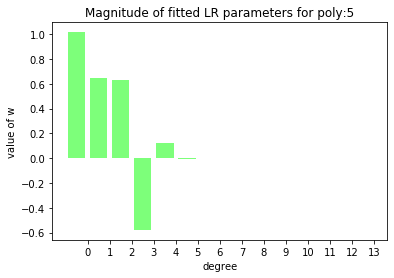

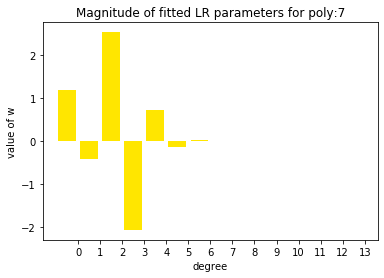

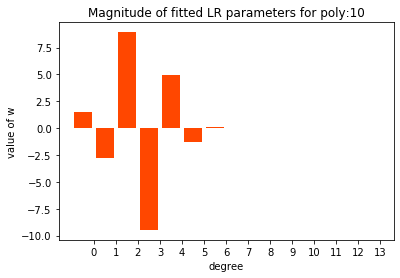

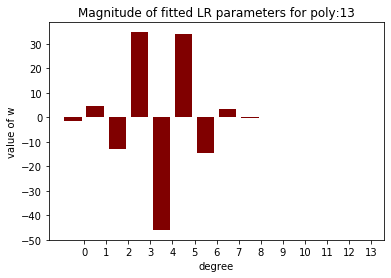

In [35]:
for ix, t in enumerate(w_list):
    degree, w = t
    fig, ax = plt.subplots()
    plt.bar(range(max(degree_list) + 1), np.hstack((w, [0]*(max(degree_list) - w.shape[0] + 1))), color=colors[ix])
    plt.title('Magnitude of fitted LR parameters for poly:%i' % degree)
    plt.xlabel('degree')
    plt.ylabel('value of w')
    ax.set_xticks(np.array(range(max(degree_list) + 1)) + 0.5)
    ax.set_xticklabels(range(max(degree_list) + 1))
    plt.show()

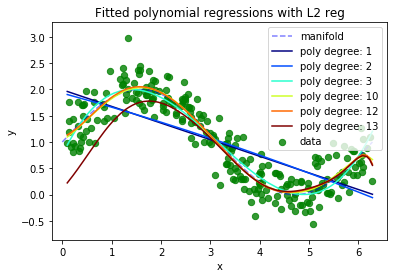

In [40]:
# define regularization parameter
lmbd = 0.1

degree_list = [1, 2, 3, 10, 12, 13]
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, len(degree_list))]

margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')

w_list_l2 = []
err = []
for ix, degree in enumerate(degree_list):
    dlist = [[1]*data['x_train'].shape[0]] + [data['x_train']**n for n in range(1, degree + 1)]
    X = np.array(dlist).T
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbd*np.eye(X.shape[1])), X.T), data['y_train'])
    w_list_l2.append((degree, w))
    y_hat = np.dot(w, X.T)
    plt.plot(data['x_train'], y_hat, color=colors[ix], label='poly degree: %i' % degree)
    err.append(np.mean((data['y_train'] - y_hat)**2))
plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 10})
plt.title('Fitted polynomial regressions with L2 reg')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [42]:
data = generate_wave_set(1000, 100)
X = np.vstack((np.ones(data['x_train'].shape[0]), data['x_train'])).T
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), data['y_train'])

c:\python36_64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


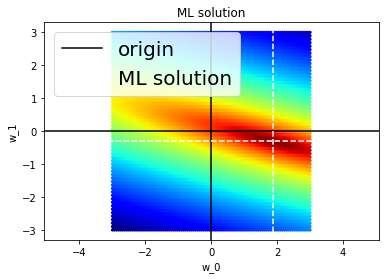

In [47]:
import itertools as it
from matplotlib import cm
w0_support = np.linspace(-3, 3, 1000)
w1_support = np.linspace(-3, 3, 1000)
# create cartesian product of parameters
wx_space = list(it.product(w0_support, w1_support))
w0, w1 = zip(*wx_space)
# calculate MSE on dataset for each pairs of parameters
y = ((data['y_train'][:, np.newaxis] - np.dot(X, np.array(wx_space).T))**2).mean(axis=0)

plt.hexbin(w0, w1, C=y**(0.2), cmap=cm.jet_r, bins=None)
plt.axvline(0, color='black', linestyle='-', label='origin')
plt.axhline(0, color='black', linestyle='-')
plt.axvline(w[0], color='w', linestyle='--', label='ML solution')
plt.axhline(w[1], color='w', linestyle='--')
plt.axes().set_aspect('equal', 'datalim')
plt.title('ML solution')
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.legend(loc='upper left', prop={'size': 20})
plt.show()